https://github.com/pythonlessons/Reinforcement_Learning/tree/master/09_Pong-v0_A2C

https://pylessons.com/A3C-reinforcement-learning/

In [1]:
#pip install gym[atari]

In [ ]:
#pip install atari-py
#pip install --upgrade gym==0.19.0

In [ ]:
#!pip install cmake
#pip install atari-py
#pip install gym[atari]

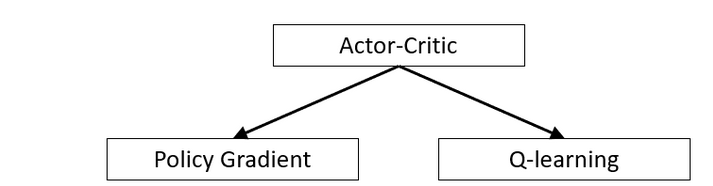

https://pylessons.com/A2C-reinforcement-learning/

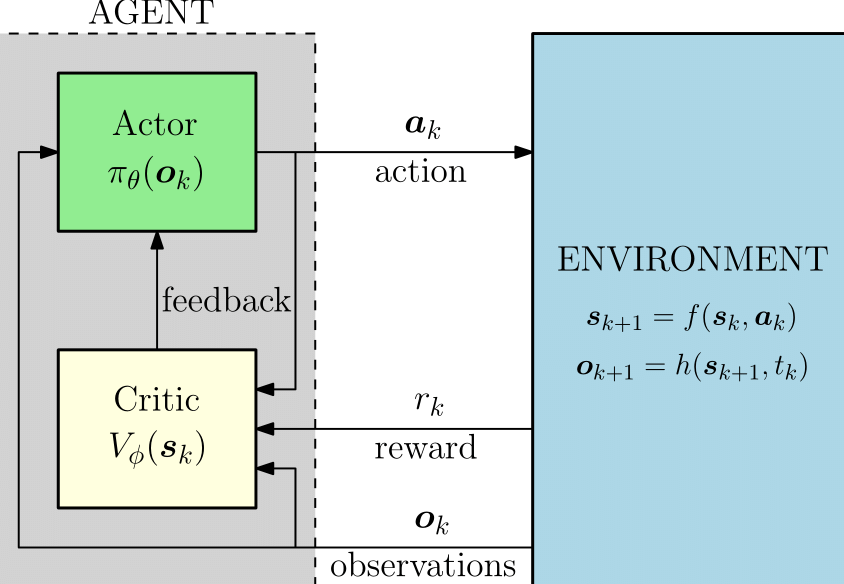

https://www.researchgate.net/profile/Lorenzo-Federici/publication/343639364/figure/fig5/AS:925509202505735@1597669997770/Schematic-of-the-Advantage-Actor-Critic-RL-process-for-a-deterministic-MDP.png

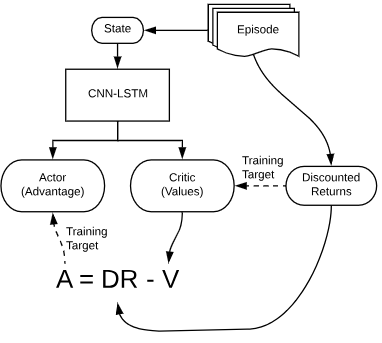

https://preview.redd.it/sqfdpqnfuzb21.png?width=385&format=png&auto=webp&s=fa1965979d5dbe95ea753ae753fff3430ba2d880

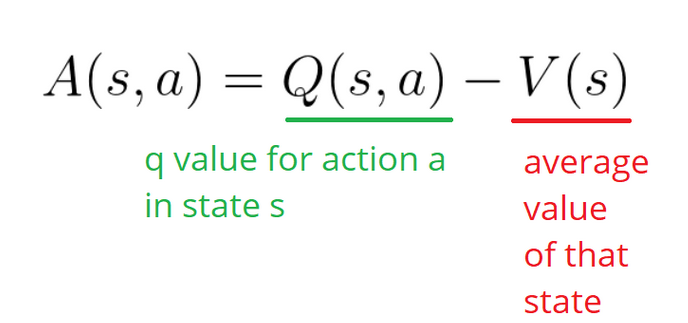

https://www.freecodecamp.org/news/an-intro-to-advantage-actor-critic-methods-lets-play-sonic-the-hedgehog-86d6240171d/

## Import libs

In [1]:


import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import random
import gym
import pylab
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import cv2
from gym.envs.registration import register

## Define the model

In [5]:


def OurModel(input_shape, action_space, lr):
    X_input = Input(input_shape)

    #X = Conv2D(32, 8, strides=(4, 4),padding="valid", activation="elu", data_format="channels_first", input_shape=input_shape)(X_input)
    #X = Conv2D(64, 4, strides=(2, 2),padding="valid", activation="elu", data_format="channels_first")(X)
    #X = Conv2D(64, 3, strides=(1, 1),padding="valid", activation="elu", data_format="channels_first")(X)
    X = Flatten(input_shape=input_shape)(X_input)

    X = Dense(512, activation="elu", kernel_initializer='he_uniform')(X)
    #X = Dense(256, activation="elu", kernel_initializer='he_uniform')(X)
    #X = Dense(64, activation="elu", kernel_initializer='he_uniform')(X)

    action = Dense(action_space, activation="softmax", kernel_initializer='he_uniform')(X)
    value = Dense(1, kernel_initializer='he_uniform')(X)

    Actor = Model(inputs = X_input, outputs = action)
    Actor.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=lr))

    Critic = Model(inputs = X_input, outputs = value)
    Critic.compile(loss='mse', optimizer=RMSprop(lr=lr))

    return Actor, Critic

class A2CAgent:
    # Actor-Critic Main Optimization Algorithm
    def __init__(self, env_name):
        # Initialization
        # Environment and PPO parameters
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.EPISODES, self.max_average = 5, -21.0 # specific for pong
        self.lr = 0.000025

        self.ROWS = 80
        self.COLS = 80
        self.REM_STEP = 4

        # Instantiate games and plot memory
        self.states, self.actions, self.rewards = [], [], []
        self.scores, self.episodes, self.average = [], [], []

        self.Save_Path = 'Models'
        self.state_size = (self.REM_STEP, self.ROWS, self.COLS)
        self.image_memory = np.zeros(self.state_size)
        
        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.path = '{}_A2C_{}'.format(self.env_name, self.lr)
        self.Model_name = os.path.join(self.Save_Path, self.path)

        # Create Actor-Critic network model
        self.Actor, self.Critic = OurModel(input_shape=self.state_size, action_space = self.action_size, lr=self.lr)


    def remember(self, state, action, reward):
        # store episode actions to memory
        self.states.append(state)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        self.actions.append(action_onehot)
        self.rewards.append(reward)


    def act(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=prediction)
        return action

    def discount_rewards(self, reward):
        # Compute the gamma-discounted rewards over an episode
        gamma = 0.99    # discount rate
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            if reward[i] != 0: # reset the sum, since this was a game boundary (pong specific!)
                running_add = 0
            running_add = running_add * gamma + reward[i]
            discounted_r[i] = running_add

        discounted_r -= np.mean(discounted_r) # normalizing the result
        discounted_r /= np.std(discounted_r) # divide by standard deviation
        return discounted_r

                
    def replay(self):
        # reshape memory to appropriate shape for training
        states = np.vstack(self.states)
        actions = np.vstack(self.actions)

        # Compute discounted rewards
        discounted_r = self.discount_rewards(self.rewards)

        # Get Critic network predictions
        values = self.Critic.predict(states)[:, 0]
        # Compute advantages
        advantages = discounted_r - values
        # training Actor and Critic networks
        self.Actor.fit(states, actions, sample_weight=advantages, epochs=1, verbose=0)
        self.Critic.fit(states, discounted_r, epochs=1, verbose=0)
        # reset training memory
        self.states, self.actions, self.rewards = [], [], []
    
    def load(self, Actor_name, Critic_name):
        self.Actor = load_model(Actor_name, compile=False)
        #self.Critic = load_model(Critic_name, compile=False)

    def save(self):
        self.Actor.save(self.Model_name + '_Actor.h5')
        #self.Critic.save(self.Model_name + '_Critic.h5')

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            pylab.plot(self.episodes, self.scores, 'b')
            pylab.plot(self.episodes, self.average, 'r')
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.savefig(self.path+".png")
            except OSError:
                pass

        return self.average[-1]

    def imshow(self, image, rem_step=0):
        cv2.imshow(self.Model_name+str(rem_step), image[rem_step,...])
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return

    def GetImage(self, frame):
        # croping frame to 80x80 size
        frame_cropped = frame[35:195:2, ::2,:]
        if frame_cropped.shape[0] != self.COLS or frame_cropped.shape[1] != self.ROWS:
            # OpenCV resize function 
            frame_cropped = cv2.resize(frame, (self.COLS, self.ROWS), interpolation=cv2.INTER_CUBIC)
        
        # converting to RGB (numpy way)
        frame_rgb = 0.299*frame_cropped[:,:,0] + 0.587*frame_cropped[:,:,1] + 0.114*frame_cropped[:,:,2]

        # convert everything to black and white (agent will train faster)
        frame_rgb[frame_rgb < 100] = 0
        frame_rgb[frame_rgb >= 100] = 255
        # converting to RGB (OpenCV way)
        #frame_rgb = cv2.cvtColor(frame_cropped, cv2.COLOR_RGB2GRAY)     

        # dividing by 255 we expresses value to 0-1 representation
        new_frame = np.array(frame_rgb).astype(np.float32) / 255.0

        # push our data by 1 frame, similar as deq() function work
        self.image_memory = np.roll(self.image_memory, 1, axis = 0)

        # inserting new frame to free space
        self.image_memory[0,:,:] = new_frame

        # show image frame   
        #self.imshow(self.image_memory,0)
        #self.imshow(self.image_memory,1)
        #self.imshow(self.image_memory,2)
        #self.imshow(self.image_memory,3)
        
        return np.expand_dims(self.image_memory, axis=0)

    def reset(self):
        frame = self.env.reset()
        for i in range(self.REM_STEP):
            state = self.GetImage(frame)
        return state

    def step(self, action):
        next_state, reward, done, info = self.env.step(action)
        next_state = self.GetImage(next_state)
        return next_state, reward, done, info
    
    def run(self):
        for e in range(self.EPISODES):
            state = self.reset()
            done, score, SAVING = False, 0, ''
            while not done:
                #self.env.render()
                # Actor picks an action
                action = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.step(action)
                # Memorize (state, action, reward) for training
                self.remember(state, action, reward)
                # Update current state
                state = next_state
                score += reward
                if done:
                    average = self.PlotModel(score, e)
                    # saving best models
                    if average >= self.max_average:
                        self.max_average = average
                        self.save()
                        SAVING = "SAVING"
                    else:
                        SAVING = ""
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(e, self.EPISODES, score, average, SAVING))

                    self.replay()
        # close environemnt when finish training
        self.env.close()

    def test(self, Actor_name, Critic_name):
        self.load(Actor_name, Critic_name)
        for e in range(100):
            state = self.reset()
            done = False
            score = 0
            while not done:
                action = np.argmax(self.Actor.predict(state))
                state, reward, done, _ = self.step(action)
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, score))
                    break
        self.env.close()



<Figure size 1296x648 with 0 Axes>

## Run training

In [6]:
if __name__ == "__main__":
   
    env_name = 'Pong-v0'

    agent = A2CAgent(env_name)
    agent.run()


episode: 0/5, score: -21.0, average: -21.00 SAVING
episode: 1/5, score: -19.0, average: -20.00 SAVING
episode: 2/5, score: -19.0, average: -19.67 SAVING
episode: 3/5, score: -21.0, average: -20.00 
episode: 4/5, score: -19.0, average: -19.80 


In [11]:
env = gym.make(env_name)

#get number of actions
num_actions=env.action_space.n
num_actions

6

In [20]:

#number of states
states = env.observation_space.shape[2]
states

3

## Testing the agent and ploting result

In [ ]:
if __name__ == "__main__":
    
    env_name = 'Pong-v0'

    agent = A2CAgent(env_name)


agent.test('Models\Pong-v0_A2C_2.5e-05_Actor.h5', '')



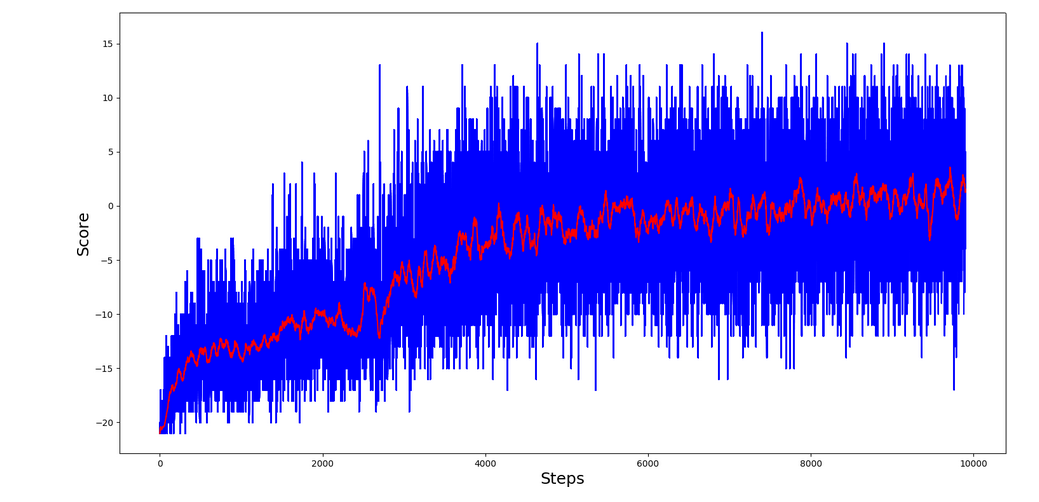
https://pylessons.com/A2C-reinforcement-learning/